# KB SYSTEM- FLASH2

In [2]:
%matplotlib inline  
#qt5  

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


#Importing necessary modules:
import os
import sys
import copy
import time
import errno
import numpy as np
import pylab as plt

from IPython.display import Image

### change `wpg_path` to root folder of the WPG installation


sys.path.insert(0,os.path.join('..','..'))

#change the path to root folder of the WPG installation

#wpg_path = '/Users/lsamoylv/code/ghub/srw_update/'

wpg_path = '../WPG-feature-srw_update_py2'
sys.path.insert(0,wpg_path)

# wpg_path = os.path.join('..','WPG')

#Import base wavefront class
from wpg import Wavefront

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront

from wpg.srwlib import srwl

#import some helpers functions
from wpg.wpg_uti_exfl import calculate_theta_fwhm_cdr_s1
from wpg.wpg_uti_wf import calc_pulse_energy, averaged_intensity, calculate_fwhm, get_intensity_on_axis
from wpg.wpg_uti_wf_cmap2 import plot_intensity_map, look_at_q_space
from wpg.wpg_uti_wf import plot_wf, look_at_q_space, plot_intensity_qmap, calc_pulse_energy
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh

ModuleNotFoundError: No module named 'srwlpy'

In [ ]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

## Design of the KB System

## Definig the source 

In [ ]:
src_to_m0 = 21.4                                # m
inc_angle = 34.9e-3

''' #Source size (FWHM, Calculations)
             4 nm - 120 mum
             8 nm - 140 mum
             12 nm - 160 mum
             20 nm - 190 mum
             60 nm - 270 mum 
'''

wl=13.5e-9                                          # m
ekev=1239/(wl*1e12)
coh_time= 5e-10                               #[fs] parms http://adweb.desy.de/home/faatz/www/FLASH-parms4.html
pulseEnergy= 1e-3;                             #[J]  parms http://adweb.desy.de/home/faatz/www/FLASH-parms4.html
w_fwhm = 120*1e-6                               # wl/(np.pi*theta_fwhm)# FWHM beam waist; 
w_0 = w_fwhm/(2*np.sqrt(np.log(2)))            # sigma of amplitude
w_rms= w_fwhm/1.36



M2=1.5935
zR= (np.pi*w_fwhm**2)/(wl*M2)
wZ=w_fwhm*np.sqrt(1+(src_to_m0/zR)**2)
wRMS=wZ*0.735
theta_fwhm=wl*M2/(np.pi*w_fwhm)

#defining limits and sample
num_points = 1200
nslices = 30  
sig_num = 5                                    #range is 5 times the size of the beam width radius;
range_xy =w_rms * np.sqrt(1+(src_to_m0/zR)**2)/np.sqrt(2)*sig_num;     


coh_length= 1/(inc_angle/(src_to_m0*theta_fwhm))


print('Divergence (FWHM)       :{:.2f} urad'.format(theta_fwhm*1e6))
print('Waist FWHM@{:.2f}m       :{:.2f} um'.format(src_to_m0,wZ*1e6))
print('Max. Spatial Coherence  :{:.2f} cm'.format(coh_length*100))
print('Range x and y           :{:.2f} mm'.format(range_xy*1e3))

data_path='KB';mkdir_p(data_path)
fname='KB2'
bSaved=True

saving WF to KB_DPH\KB2.h5
FWHM at distance 21.4 m: 1.7292 x 1.7292 mm2


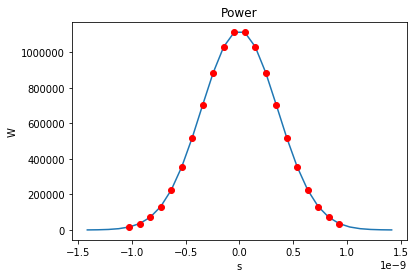

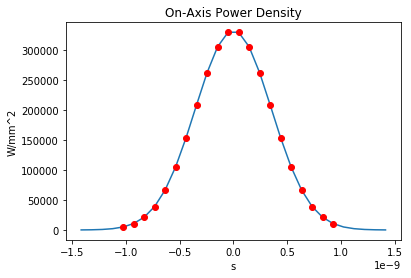

number of meaningful slices: 21
Pulse energy 0.00099 J
R-space
(1200,) (1200,)


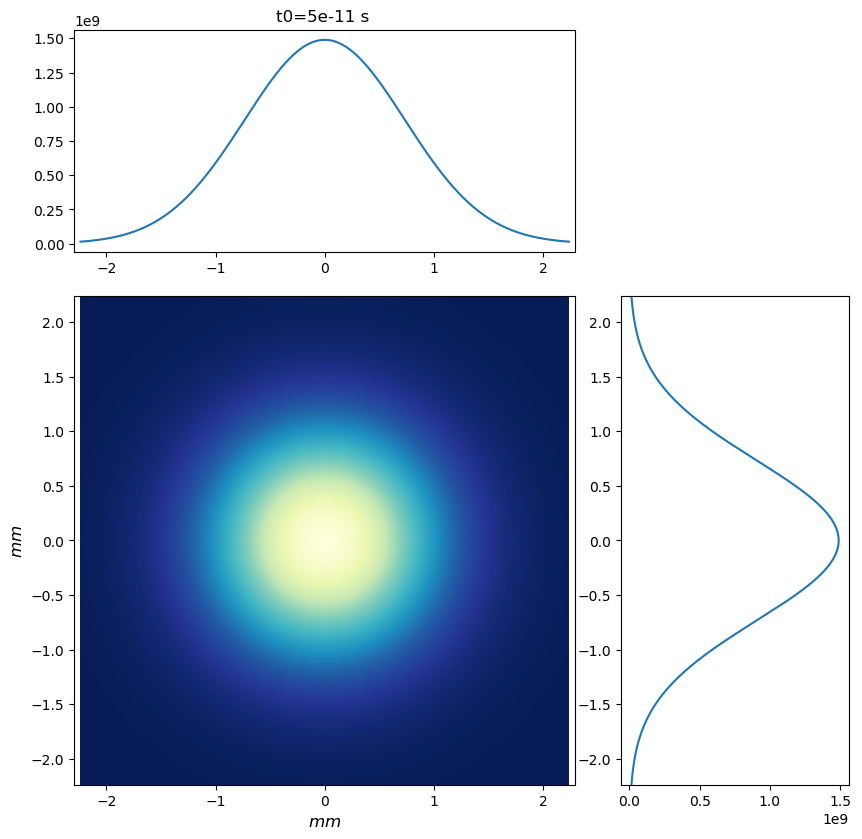

In [18]:
srwl_wf = build_gauss_wavefront(num_points, num_points, nslices, 
                                ekev, -range_xy/2, range_xy/2, -range_xy/2, range_xy/2, coh_time/np.sqrt(2), 
                                w_rms/2, w_rms/2, src_to_m0, pulseEn=pulseEnergy, 
                                pulseRange=None, _mx=0, _my=0)
wf = Wavefront(srwl_wf)

data_path='KB_DPH';mkdir_p(data_path)
fname='KB2'

bSaved=True
if bSaved:     
    wf.store_hdf5(os.path.join(data_path,fname+'.h5')); 
    print('saving WF to {:s}'.format(os.path.join(data_path,fname+'.h5')))

fwhm=calculate_fwhm(wf);
print('FWHM at distance {:.1f} m: {:.4f} x {:.4f} mm2'.format(src_to_m0,fwhm[u'fwhm_x']*1e3,fwhm[u'fwhm_y']*1e3));
#plot the source
plot_wf(wf)


## Defining optical elements

'''
mirror_data = np.loadtxt('data_flash2/M3_510mm_height.dat'); 
offset_x=1e-3;
mirror_data[:,0] *= offset_x 
offset_x=-0.255;
mirror_data[:,0] += offset_x 

offset_y=1e-9;
mirror_data[:,1] *= offset_y 

np.savetxt('data_flash2/M3_510mm_height_conv.dat',mirror_data)

'''
#KB
kb_mirror_data= np.zeros((181, 2))
kb_mirror_data[:,0] = np.arange(-0.180, 0.182, 0.002)
kb_data = ((np.loadtxt('data_flash2/kbvertical.dat'))); 
kb_data = kb_data-min(kb_data);
kb_mirror_data[:,1]=kb_data/1000;

np.savetxt('data_flash2/kbvertical_conv.dat',kb_mirror_data)


In [50]:
%%file beamline_EllKB.py

def get_beamline():
    import os
    import wpg
    from wpg import Beamline
    from wpg.optical_elements2 import Aperture, Drift, Empty, Use_PP, Mirror_plane, Mirror_elliptical_mis, Lens
    from wpg.wpg_uti_oe import show_transmission


    mirrors_path = 'data_flash2' #'datacommon'#
    
    
    #-------1. Geometry--------
    
    #--1.1. Distances----------
    src_to_oe1 =   21.40                       #[m]  Distance between the source and the first optical element- offset mirror
    oe1_to_oe2 =    1.40                       #[m]  Distance between offset mirrors
    oe2_to_pm  =   63.40                       #[m]  Distance between the source and the planar mirror
    pm_to_kb1 =     1.50                       #[m]  Distance between the planar mirror and the first KB
    kb1_to_kb2 =    0.55                       #[m]  Distance between the Kb horizontal(1) and Kb vertical (2)
    kb2_to_screen = 2.0                        #[m]  Distance between the Kb2 and the screen
    
    
    #--1.2. Angles-------------
    
    theta_i= 34.9e-3                          #[rad] Angle of incidence
    pitch1 =0.0e-4                            # Change beam vertically
    pitch2 =0.0e-4                            # Change beam horizontally
    roll1= 0.0e-4
    roll2= 0.0e-3
     
    #--1.3. Dimensions---------
    mirror_diam = 0.50                        #[m] Diameter of the Optical Elements 
    ap_x_y_ratio = 1
    om_projection = mirror_diam*theta_i
    range_xy = om_projection*ap_x_y_ratio
    zoom = 1.5
    
    bl = Beamline()
    
    


    
    #-------2. Elements--------
    #OE1: Offset mirror 1 
    PM = Aperture(shape='r', ap_or_ob='a', Dx=0.8, Dy=0.8)
    bl.append(PM, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))

    PM_distorsions = Mirror_plane(orient='x',
                                  theta=theta_i, 
                                  length=0.8, 
                                  range_xy=theta_i*0.8, 
                                  filename=os.path.join(
                                  mirrors_path,'M1_800mm_height_conv.dat'),
                                  scale=1, 
                                  x0=0,  
                                  xscale=1., 
                                  bPlot=True)                                         
    #print('PM WF distortion'); show_transmission(PM_distorsions);
    bl.append(PM_distorsions, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))

    bl.append(Drift(oe1_to_oe2), Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    
     #OE2: Offset mirror 2
    PM = Aperture(shape='r', ap_or_ob='a', Dx=0.8, Dy=0.8)
    bl.append(PM, Use_PP(semi_analytical_treatment=0, zoom=1, sampling=1))

    PM_distorsions = Mirror_plane(orient='x',
                                  theta=theta_i, 
                                  length=0.8, 
                                  range_xy=theta_i*0.8, 
                                  filename=os.path.join(
                                  mirrors_path,'M2_800mm_height_conv.dat'), #'mj37_2.dat'),#
                                  scale=1, 
                                  x0=0, 
                                  xscale=1.,
                                  bPlot=True)                                         
    #print('PM WF distortion'); show_transmission(PM_distorsions);
    bl.append(PM_distorsions,
               Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))

    bl.append(Drift(63), Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    
    
    
    
    ##Apertures set------------3mm, 5mm, 7mm, 8.8mm, 10mm and 14mm ---------------------------------- 
    
    Apertureset = Aperture(shape='c', ap_or_ob='a', Dx=0.014, Dy=0.014)
    bl.append(Apertureset, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    bl.append(Drift(1.4), Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
    
    ##-----------------------------------------------------------------------------------------------




    #Planar mirror
    PM = Aperture(shape='r', ap_or_ob='a', Dx=0.50, Dy=0.50)
    bl.append(PM, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))

    PM_distorsions = Mirror_plane(orient='y',
                                  theta=theta_i, 
                                  length=0.5, 
                                  range_xy=theta_i*0.5, 
                                  filename=os.path.join(
                                  mirrors_path,'M3_510mm_height_conv.dat'), #'mj37_2.dat'),#
                                  scale=1, 
                                  x0=0, 
                                  xscale=1.,
                                  bPlot=True)                                         
    #print('PM WF distortion'); show_transmission(PM_distorsions);
    bl.append(PM_distorsions, Use_PP(semi_analytical_treatment=0, zoom=1, sampling=1))

    bl.append(Drift(pm_to_kb1), Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
   
   
   
    
    
    
     
    #--2.2. Elliptical mirror KB1--
   
    
    
    KB1_ap = Aperture(
           shape='r', ap_or_ob='a', Dx=0.36, Dy=0.02)
    bl.append(KB1_ap, Use_PP(semi_analytical_treatment=1))
    KB1= Mirror_elliptical_mis(orient='y',
                          p=87.7, 
                          q=1.992+0.55, #1.991
                          thetaE=theta_i, 
                          theta0=theta_i+pitch1, 
                          length=1,
                          roll=0e-3,
                          yaw=0e-6, 
                          distance=6.0)             #horizontal coordinate of central normal vector [m]
    
    bl.append(KB1, Use_PP(semi_analytical_treatment=0, zoom=1, sampling=1))
    KB1_profile= Mirror_plane(orient='y',
                              theta=theta_i, 
                              length=0.36, 
                              range_xy=theta_i*0.36, 
                              filename=os.path.join(
                              mirrors_path,'kbvertical_conv.dat'), #'mj37_2.dat'),#
                              scale=1, 
                              x0=0, 
                              xscale=1.,
                              bPlot=True)                                         
    #print('PM KB1_profile'); show_transmission(KB1_profile);
    bl.append(KB1_profile, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
   
    
    
    KB1_2_KB2_drift = Drift(0.55)
    bl.append( KB1_2_KB2_drift, 
               Use_PP(semi_analytical_treatment=1))

   
  
    
    
    
    #--2.2. Elliptical mirror KB2--
    
    KB2_ap = Aperture(shape='r', ap_or_ob='a', Dx=0.02, Dy= 0.36)
    bl.append(KB2_ap, Use_PP(semi_analytical_treatment=1))
    KB2= Mirror_elliptical_mis(orient='x',
                          p=88.25, 
                          q=2.002,
                          thetaE=theta_i, 
                          theta0=theta_i+pitch2, 
                          length=1,
                          roll=0e-3,
                          yaw=0e-6, 
                          distance=6.0)                #horizontal coordinate of central normal vector [m]
    
    bl.append(KB2, Use_PP(semi_analytical_treatment=0, zoom=1, sampling=1))
    KB2_profile= Mirror_plane(orient='x',
                              theta=theta_i, 
                              length=0.36, 
                              range_xy=range_xy, 
                              filename=os.path.join(
                              mirrors_path,'kbhorizontal_conv.dat'), #'mj37_2.dat'),#
                              scale=1, 
                              x0=0, 
                              xscale=1., 
                              bPlot=True)                                         
    #print('PM KB1_profile'); show_transmission(KB2_profile);
    bl.append(KB2_profile, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))
       
    
    
    KB2_to_imageplane_drift2 = Drift(2.000)
    bl.append(KB2_to_imageplane_drift2,Use_PP(semi_analytical_treatment=1))

      
     
          
    return bl

Overwriting beamline_EllKB.py


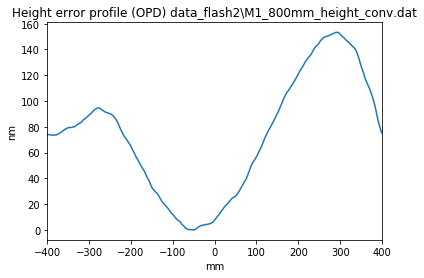

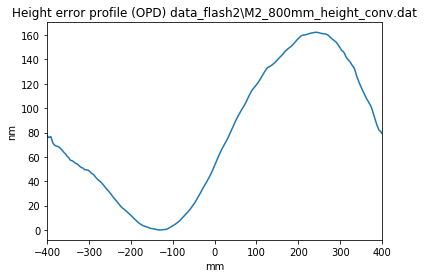

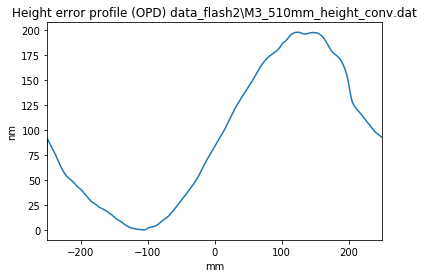

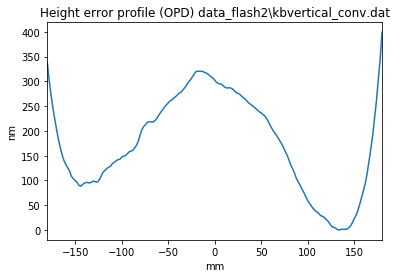

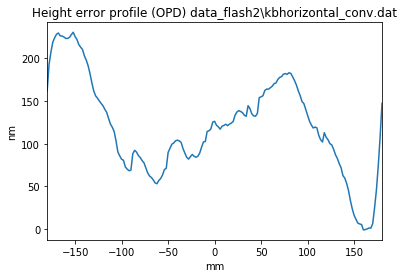

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.8
	Dy = 0.8
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.01396
		xStart = -0.01396
		yFin = 0.01396
		yStart = -0.01396
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 1.4
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.8
	Dy = 0.8
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+2

In [51]:
#loading beamline from file
import imp
custom_beamline = imp.load_source('custom_beamline', 'beamline_EllKB.py')
get_beamline = custom_beamline.get_beamline
bl = get_beamline()
print(bl)

wf=Wavefront()

full_fname = os.path.join(data_path,fname+'.h5')  # wavefront file
wf.load_hdf5(full_fname)

srwl.SetRepresElecField(wf._srwl_wf, 'f') # <---- switch to frequency domain

bl.propagate(wf)

fwhm=calculate_fwhm(wf);
print('FWHM at focal:            {:.2f} x {:.2f} um2 '.format(fwhm[u'fwhm_x']*1e6,fwhm[u'fwhm_y']*1e6));
print('RMS at focal:             {:.2f} x {:.2f} um2 '.format(fwhm[u'fwhm_x']*0.735e6,fwhm[u'fwhm_y']*0.735e6));
print('4sigma(Mr Beam) at focal: {:.2f} x {:.2f} um2 '.format(fwhm[u'fwhm_x']*1.7e6,fwhm[u'fwhm_y']*1.7e6));

Showing the propagated beam after KAOS
FWHM:            1.88 x 3.18 um2 
4sigma(Mr Beam): 3.19 x 5.41 um2 
R-space
(1200,) (1200,)


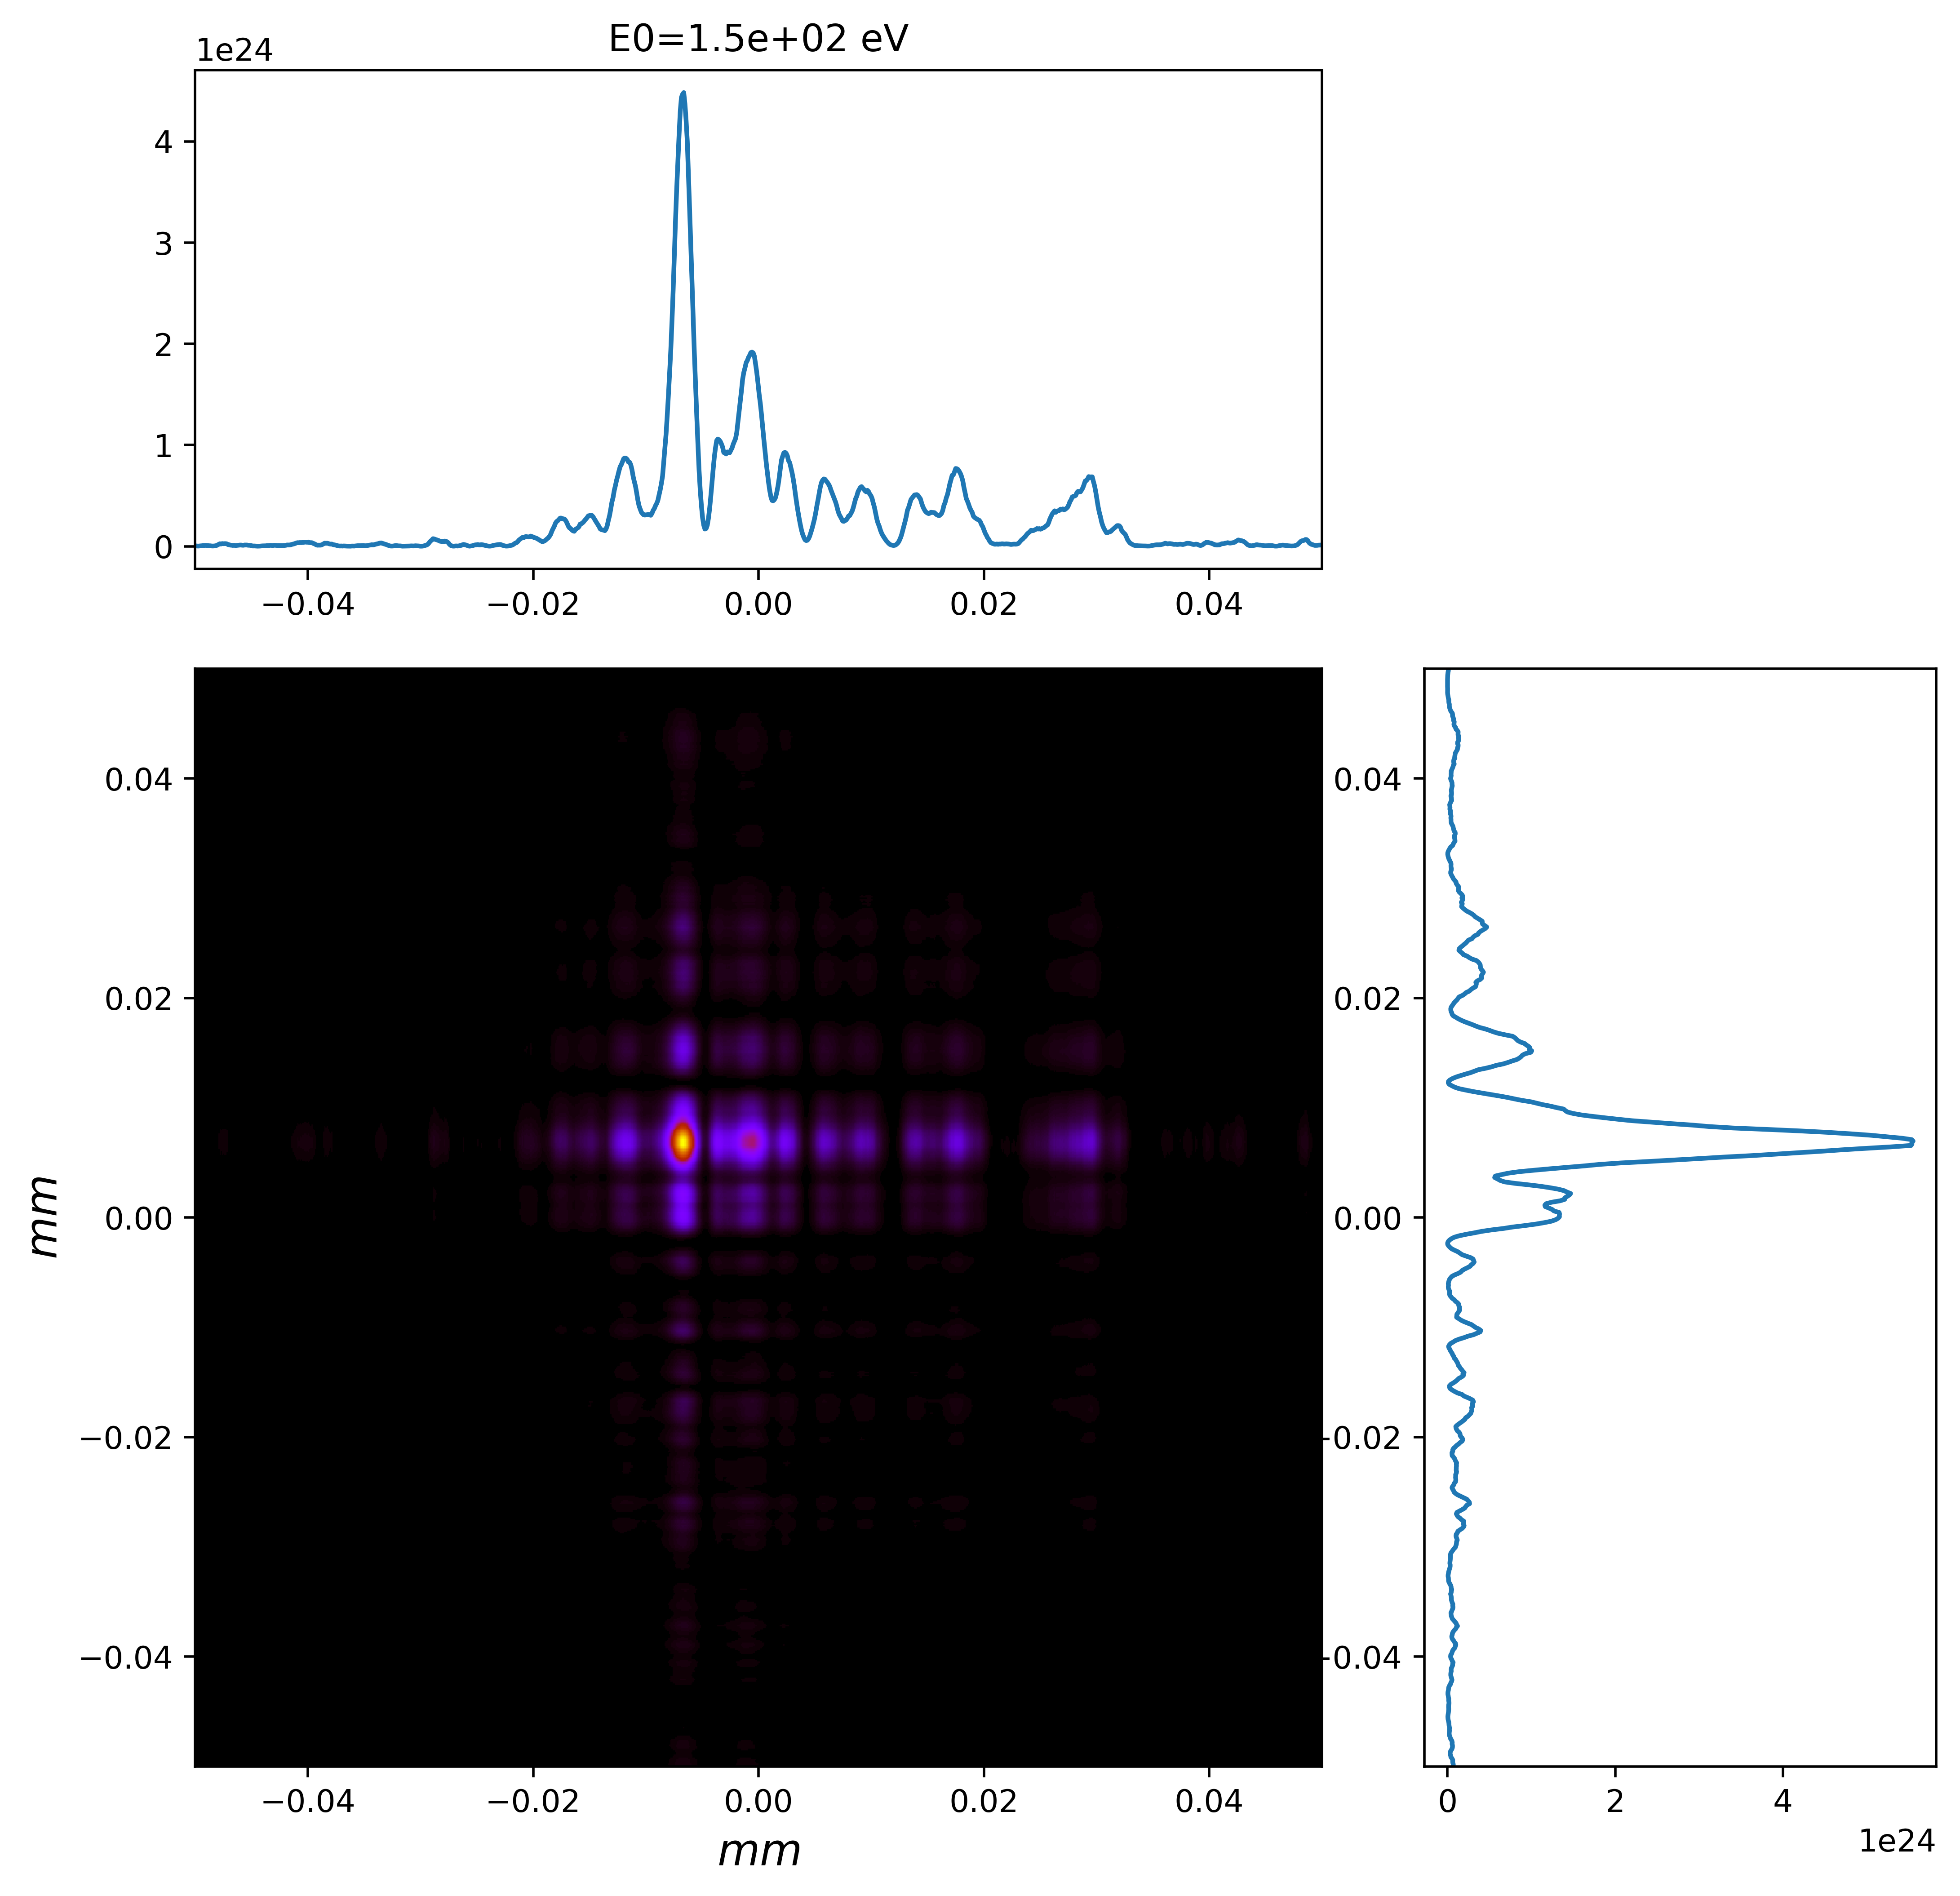

In [52]:
print('Showing the propagated beam after KAOS')

xx=calculate_fwhm(wf);
print('FWHM:            {:.2f} x {:.2f} um2 '.format(fwhm[u'fwhm_x']*1e6,fwhm[u'fwhm_y']*1e6));
print('4sigma(Mr Beam): {:.2f} x {:.2f} um2 '.format(fwhm[u'fwhm_x']*1.7e6,fwhm[u'fwhm_y']*1.7e6));
#plot_wf(wf)   
plot_intensity_map(wf, save='', range_x=0.1, range_y=0.1, im_aspect='auto');  


